In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import random
from torch.utils.data import DataLoader, random_split, Subset
from torchvision.models import resnet18
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit , StratifiedKFold
import numpy as np
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the random seed for reproducibility
set_seed(42)

In [3]:
#defining class names for use
classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

num_classes = len(classes)

# Generating input data for fine tuning

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

100%|██████████| 170498071/170498071 [00:08<00:00, 20689701.36it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
#Stratified split
trainset_targets = trainset.targets
# Define StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
# Split the dataset into 70%(35000) and 30%(15000) sets
unused_idx, used_idx = next(sss.split(trainset.data, trainset_targets))
unused_subset = Subset(trainset, unused_idx)
used_subset = Subset(trainset, used_idx)
print(len(unused_subset))
print(len(used_subset))

# Prepare targets for used_subset
used_targets = [trainset_targets[i] for i in used_idx]
# Second split: 80% (train - 12000) and 20% (validation - 3000) of used_subset
sssplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sssplit.split(used_idx, used_targets))
train_data = Subset(trainset, [used_idx[i] for i in train_idx])
val_data = Subset(trainset, [used_idx[i] for i in val_idx])
print(len(train_data))
print(len(val_data))

35000
15000
12000
3000


In [6]:
# load fine-tuning data
finetunedata_loader = DataLoader(train_data, batch_size=256, shuffle=True)
num_batches = len(finetunedata_loader)
print(num_batches)

47


In [7]:
# load validation data
val_loader = DataLoader(val_data, batch_size=256, shuffle=False)

# Contrastive Learning - Fine Tuning

Creating fine-tuning Model

In [8]:
class FineTuneModel(nn.Module):
    def __init__(self, num_classes, encoder_save_path):
        super().__init__()
        
        # Initialize ResNet-18 without pretrained weights
        self.tr_enc = resnet18(pretrained=False) 
        self.feature_dim = self.tr_enc.fc.in_features # feature dim = output of gap layer dim or input of FC layer dim
        
        # Customize for CIFAR10. Replace conv 7x7 with conv 3x3, and remove first max pooling.
        # See Section B.9 of SimCLR paper.
        self.tr_enc.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.tr_enc.maxpool = nn.Identity()
        self.tr_enc.fc = nn.Identity()  # remove final fully connected layer.
        self.tr_enc.load_state_dict(torch.load(encoder_save_path))
        
        # Add Classifier.
        self.classifier = nn.Linear(self.feature_dim, num_classes, bias=True)
        
    def forward(self, x):
        feature = self.tr_enc(x)
        label = self.classifier(feature)
        return label

In [9]:
fine_tune_model = FineTuneModel(num_classes=10, encoder_save_path='/kaggle/input/simclr-pretrainedencoders/encoder_e50_lr0p001_lrs60per10.pth')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fine_tune_model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FineTuneModel(
  (tr_enc): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
       

In [10]:
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss for multi-class classification
optimizer = optim.Adam(fine_tune_model.parameters(), lr=0.0008)

In [11]:
# ExponentialLR scheduler for learning rate decay
exp_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

1 fold

In [12]:
num_epochs = 20
switch_epoch = 15
for epoch in range(num_epochs):
    for param_group in optimizer.param_groups:
        print(f'Start of Epoch {epoch+1}/{num_epochs}, Learning Rate: {param_group["lr"]:.6f}')
    fine_tune_model.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss, it is used to accumulate the total loss of all elements in a epoch
    counter = 1
    for inputs, labels in finetunedata_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Forward pass
        outputs = fine_tune_model(inputs) #Compute predicted outputs by passing inputs to the model
        loss = criterion(outputs, labels) #Calculate the loss
      
        # Backward pass and optimization
        optimizer.zero_grad()   # Step 1: Clear old gradients
        loss.backward()         # Step 2: Compute new gradients, i.e Backward pass: Compute gradient of the loss with respect to model parameters
        optimizer.step()        # Step 3: Update model parameters
        running_loss += loss.item() * inputs.size(0)  # Accumulate loss. loss.item gives the avg loss of batch extrated from the loss tensor, input.size(0) gives the batch size, so * gives total loss in a batch
        #if counter % 10 == 0:
        #    print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{counter}/{num_batches}], Loss: {loss.item():.4f}")
        counter += 1

    epoch_loss = running_loss / len(finetunedata_loader.dataset)  # Running loss has total loss in an epoch, divide it by epoch size gives average loss in an epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    # validate the model
    fine_tune_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = fine_tune_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
    print(f'Accuracy of the model on the 3000 validation images: {accuracy:.2f}%')
    
    #Training accuracy
    fine_tune_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in finetunedata_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = fine_tune_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
    print(f'Accuracy of the model on the 12000 train images: {accuracy:.2f}%')    
  
    if epoch+1 >= switch_epoch:
        exp_scheduler.gamma =  0.6   #10.0/(epoch+1) #
    exp_scheduler.step()  # Update learning rate scheduler
    #step_scheduler.step()
  

Start of Epoch 1/20, Learning Rate: 0.000800
Epoch 1/20, Loss: 1.0652
Accuracy of the model on the 3000 validation images: 61.83%
Accuracy of the model on the 12000 train images: 64.83%
Start of Epoch 2/20, Learning Rate: 0.000720
Epoch 2/20, Loss: 0.7511
Accuracy of the model on the 3000 validation images: 69.67%
Accuracy of the model on the 12000 train images: 73.87%
Start of Epoch 3/20, Learning Rate: 0.000648
Epoch 3/20, Loss: 0.6496
Accuracy of the model on the 3000 validation images: 72.07%
Accuracy of the model on the 12000 train images: 77.29%
Start of Epoch 4/20, Learning Rate: 0.000583
Epoch 4/20, Loss: 0.5838
Accuracy of the model on the 3000 validation images: 73.27%
Accuracy of the model on the 12000 train images: 78.55%
Start of Epoch 5/20, Learning Rate: 0.000525
Epoch 5/20, Loss: 0.5319
Accuracy of the model on the 3000 validation images: 75.70%
Accuracy of the model on the 12000 train images: 82.46%
Start of Epoch 6/20, Learning Rate: 0.000472
Epoch 6/20, Loss: 0.4918


5-Fold Cross validation

In [14]:
trainset_targets = trainset.targets
# Stratified split to get 30% of the data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
_, used_idx = next(sss.split(trainset.data, trainset_targets))
used_subset = Subset(trainset, used_idx)

# Prepare targets for used_subset
used_targets = [trainset_targets[i] for i in used_idx]

# Stratified K-Fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
Loss = torch.zeros(5, 20)
Validation_accuracy = torch.zeros(5, 20)
Train_accuracy = torch.zeros(5, 20)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for fold, (train_idx, val_idx) in enumerate(kf.split(np.zeros(len(used_targets)), used_targets)):
    print(f'Fold {fold + 1}')
    train_data = Subset(used_subset, train_idx)
    val_data = Subset(used_subset, val_idx)

    train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=256, shuffle=False)

    # Create an instance of the fine-tuning model
    FT_model = FineTuneModel(num_classes=10, encoder_save_path='/kaggle/input/simclr-pretrainedencoders/encoder_e50_lr0p001_lrs60per10.pth')
    FT_model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(FT_model.parameters(), lr=0.0008)
    exp_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    # Training
    num_epochs = 20
    switch_epoch = 15
    for epoch in range(num_epochs):
        FT_model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = FT_model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        Loss[fold, epoch] = epoch_loss
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

        # Validation Accuracy
        FT_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = FT_model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
        val_accuracy = 100 * correct / total
        Validation_accuracy[fold, epoch] = val_accuracy
        print(f'Validation Accuracy on fold {fold + 1}, Epoch {epoch + 1}/{num_epochs}: {val_accuracy:.2f}%')
        
        # Training Accuracy
        FT_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = FT_model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
        Tr_accuracy = 100 * correct / total
        Train_accuracy[fold, epoch] = Tr_accuracy
        print(f'Training Accuracy on fold {fold + 1}, Epoch {epoch + 1}/{num_epochs}: {Tr_accuracy:.2f}%')
        
        if epoch + 1 >= switch_epoch:
            exp_scheduler.gamma = 0.6
        exp_scheduler.step()
        
    
# Calculate the mean along dim=0
average_loss = Loss.mean(dim=0)
average_validation_accuracy = Validation_accuracy.mean(dim=0)
average_train_accuracy = Train_accuracy.mean(dim=0)


Fold 1


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/20, Loss: 1.0553
Validation Accuracy on fold 1, Epoch 1/20: 69.80%
Training Accuracy on fold 1, Epoch 1/20: 70.16%
Epoch 2/20, Loss: 0.7405
Validation Accuracy on fold 1, Epoch 2/20: 70.77%
Training Accuracy on fold 1, Epoch 2/20: 72.07%
Epoch 3/20, Loss: 0.6549
Validation Accuracy on fold 1, Epoch 3/20: 71.43%
Training Accuracy on fold 1, Epoch 3/20: 73.66%
Epoch 4/20, Loss: 0.5901
Validation Accuracy on fold 1, Epoch 4/20: 76.37%
Training Accuracy on fold 1, Epoch 4/20: 79.14%
Epoch 5/20, Loss: 0.5380
Validation Accuracy on fold 1, Epoch 5/20: 76.67%
Training Accuracy on fold 1, Epoch 5/20: 79.66%
Epoch 6/20, Loss: 0.4956
Validation Accuracy on fold 1, Epoch 6/20: 79.10%
Training Accuracy on fold 1, Epoch 6/20: 83.38%
Epoch 7/20, Loss: 0.4541
Validation Accuracy on fold 1, Epoch 7/20: 78.53%
Training Accuracy on fold 1, Epoch 7/20: 83.97%
Epoch 8/20, Loss: 0.4295
Validation Accuracy on fold 1, Epoch 8/20: 78.80%
Training Accuracy on fold 1, Epoch 8/20: 84.85%
Epoch 9/20, Loss

printing the loss, val_acc and train_acc

In [15]:
print(f'avg loss = {average_loss}')
print(f'avg validation accuracy: {average_validation_accuracy}')
print(f'avg train accuracy = {average_train_accuracy}')

avg loss = tensor([1.0624, 0.7441, 0.6541, 0.5843, 0.5382, 0.4972, 0.4556, 0.4288, 0.3973,
        0.3697, 0.3480, 0.3267, 0.3088, 0.2948, 0.2776, 0.2562, 0.2410, 0.2260,
        0.2236, 0.2229])
avg validation accuracy: tensor([68.2867, 70.6067, 72.9533, 74.9133, 76.2733, 77.2600, 77.5533, 78.6133,
        79.2467, 79.4000, 80.8467, 80.5400, 80.7533, 81.4200, 81.4600, 81.8667,
        82.5600, 82.6400, 82.7000, 82.5667])
avg train accuracy = tensor([69.3800, 72.5850, 76.7900, 78.6583, 80.6767, 82.8417, 84.0033, 85.0533,
        86.3083, 86.5983, 88.4317, 89.1450, 89.3567, 90.4250, 90.9483, 91.9467,
        92.4067, 92.6800, 92.5900, 92.9233])


plotting the loss, val_acc and train_acc

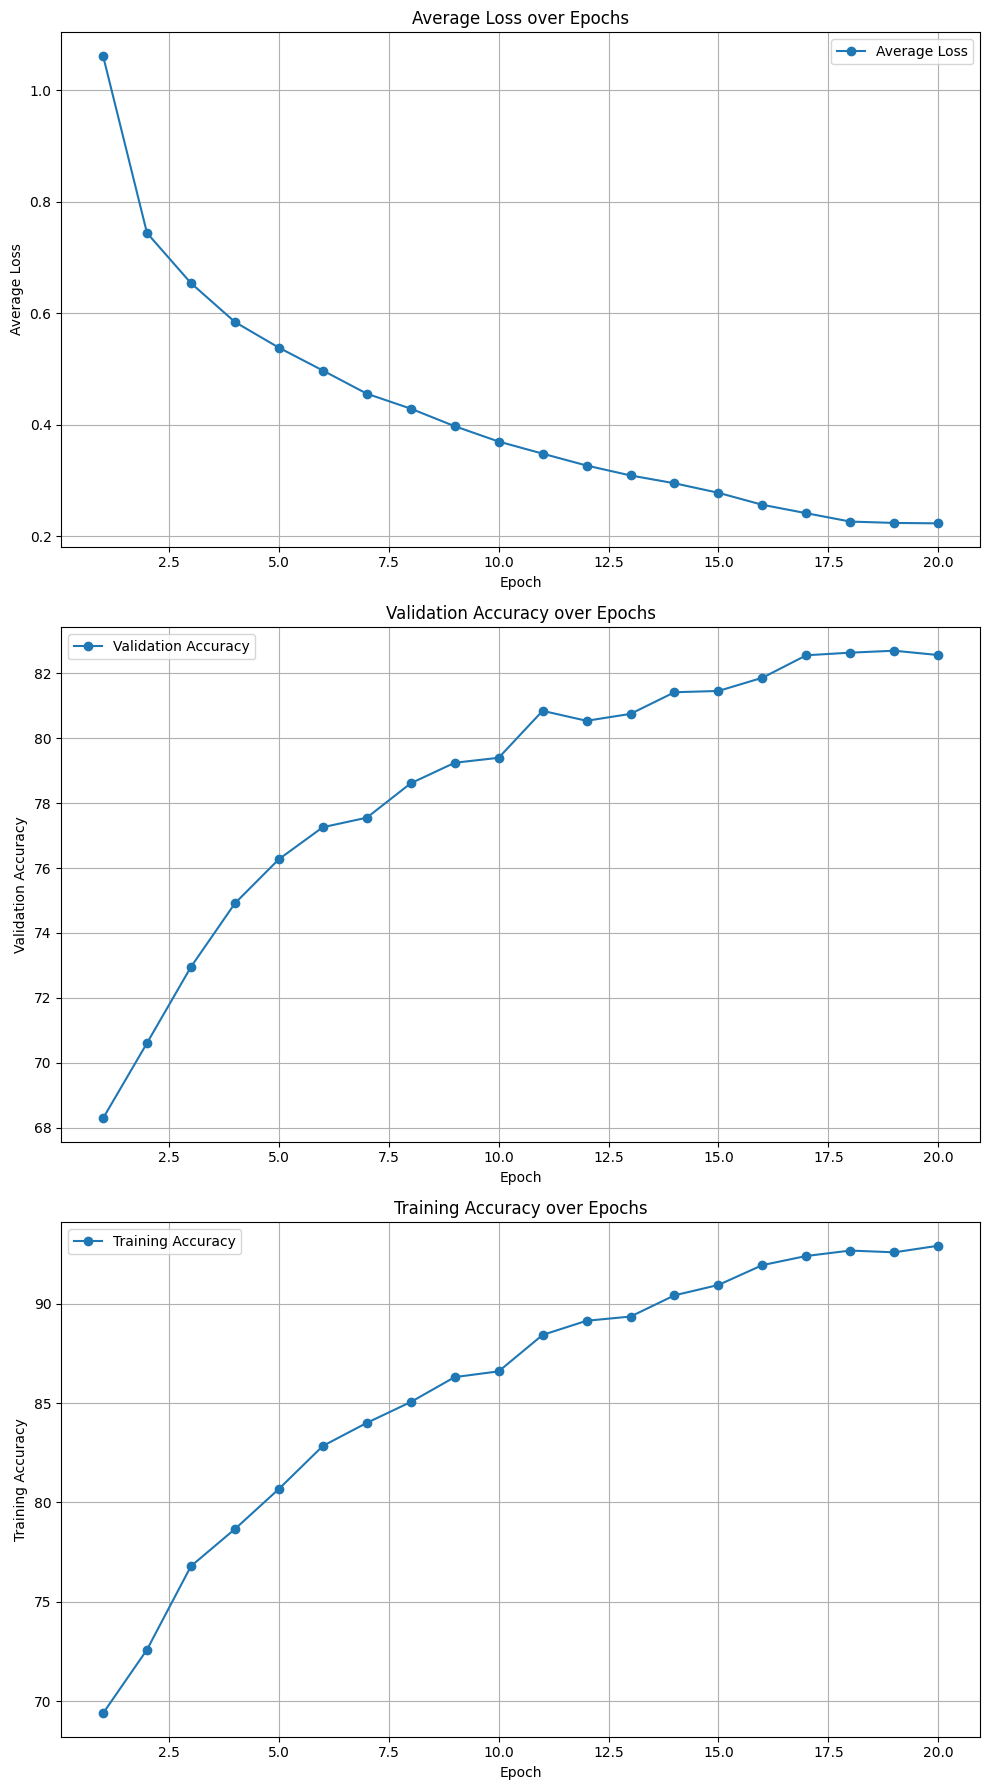

In [16]:
# Epoch numbers from 1 to 20
epochs = list(range(1, 21))

# Create the figure and subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# Plot Average Loss
axes[0].plot(epochs, average_loss, label='Average Loss', marker='o')
axes[0].set_title('Average Loss over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Average Loss')
axes[0].legend()
axes[0].grid(True)  # Add grid

# Plot Validation Accuracy
axes[1].plot(epochs, average_validation_accuracy, label='Validation Accuracy', marker='o')
axes[1].set_title('Validation Accuracy over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy')
axes[1].legend()
axes[1].grid(True)  # Add grid

# Plot Training Accuracy
axes[2].plot(epochs, average_train_accuracy, label='Training Accuracy', marker='o')
axes[2].set_title('Training Accuracy over Epochs')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Training Accuracy')
axes[2].legend()
axes[2].grid(True)  # Add grid

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Test accuracy

In [17]:
# load test data
test_loader = DataLoader(testset, batch_size=256, shuffle=False)

1 fold test accuracy

In [20]:
fine_tune_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = fine_tune_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the 10000 test images: {accuracy:.2f}%')

Accuracy of the model on the 10000 test images: 84.87%


5 fold test accuracy

In [21]:
FT_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = FT_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the 10000 test images: {accuracy:.2f}%')

Accuracy of the model on the 10000 test images: 85.28%
